In [1]:
import requests
import pandas as pd
import os
import time
import pyodbc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.display.max_rows = 999
ses = requests.Session()

In [2]:
# объявляем константы
TOKEN = ''
COUNTER_ID = 
HEADERS = {'Authorization':f'OAuth {TOKEN}'}
GOALS_URL = f'https://api-metrika.yandex.net/management/v1/counter/{COUNTER_ID}/goals'
LOGS_URL = f'https://api-metrika.yandex.net/management/v1/counter/{COUNTER_ID}/logrequests'
LOG_URL = f'https://api-metrika.yandex.net/management/v1/counter/{COUNTER_ID}/logrequest'

In [3]:
# читаем и сохраняем в переменную поля визитов(visits)
with open('visits_fields.csv', mode='r') as csv:
    visit_fields = ','.join(csv.read().split(',\n'))
# читаем и сохраняем в переменную поля просмотров(hits)
with open('views_fields.csv', mode='r') as csv:
    views_fields = ','.join(csv.read().split(',\n'))   

In [4]:
# определяем параметры для запроса визитов(visits)
params_visits = {
        'date1': '2023-01-02',
        'date2': '2024-01-07',
        'fields': visit_fields,
        'source': 'visits',
        'attribution': 'lastsign'
         }

# определяем параметры для запроса просмотров(hits)
params_views = {
        'date1': '2023-01-02',
        'date2': '2024-01-07',
        'fields': views_fields,
        'source': 'hits'
         }

In [5]:
# определяем функции

# оценка возможности создания запроса
def log_evaluate(params):
    """Function for evaluate request. Return bool."""
    response = ses.get(url=f'{LOGS_URL}/evaluate', params=params, headers=HEADERS)
    return response.json().get('log_request_evaluation').get('possible')

# создание запроса логов
def log_create(params):
    """Function for create log. Return request_id and source type."""
    response = ses.post(url=LOGS_URL, params=params, headers=HEADERS)
    return response.json().get('log_request').get('request_id'), response.json().get('log_request').get('source')

# информация о запросе логов и загрузка в csv результатов
def log_load(log_pair):
    """Function check status of the log if it is ready for load.
When query is processed save it on the local in csv format 
and then return all data in Pandas dataframe."""
    log_request_status = ses.get(url=f'{LOG_URL}/{log_pair[0]}', headers=HEADERS)
    status = log_request_status.json().get('log_request').get('status')
    while status != 'processed':
        time.sleep(30)
        print(f'status is {status}, is waiting for 30 seconds...')
        log_request_status = ses.get(url=f'{LOG_URL}/{log_pair[0]}', headers=HEADERS)
        status = log_request_status.json().get('log_request').get('status')
    else:
        file_list = []
        for part in log_request_status.json().get('log_request').get('parts'):
            part_num = part.get('part_number')
            part_download = ses.get(url=f'{LOG_URL}/{log_pair[0]}/part/{part_num}/download', headers=HEADERS)
            if part_download.ok:
                file_name = f'{log_pair[1]}/{log_pair[1]}_logs_{part_num}.csv'
                if not os.path.exists(os.path.dirname(file_name)):
                    dir_name = os.path.dirname(file_name)
                    os.makedirs(dir_name)
                else:
                    pass
                with open(file_name, mode='w', encoding='utf-8') as w_file:
                    w_file.write(part_download.text)
                file_list.append(file_name)
                print(f'{file_name} been written')
            else:
                pass
        df_list = []                
        for file in file_list:
            df_list.append(pd.read_csv(file, sep='\t'))
    return pd.concat(df_list)

# получение списка логов доступных для загрузки
def get_available_logs():
    """Function return a list of log requests that available for load"""
    logs = ses.get(url=LOGS_URL, headers=HEADERS)
    return [(log.get('request_id'), log.get('source')) for log in logs.json().get('requests')]

# очистка выгруженных логов в метрике
def clear_logs(request_id):
    """Function for deleting a request from the metrica server.
Once deleted it will not be available for load"""
    del_request = ses.post(url=f'{LOG_URL}/{request_id}/clean?',headers=HEADERS)
    return del_request.text

# получение списка целей
def get_goals():
    return pd.DataFrame(ses.get(GOALS_URL, headers=HEADERS).json()['goals'])

Получим список целей (желаемых действий пользователя на нашей странице), которые заведены в Яндекс.Метрике.

In [6]:
goals_all = get_goals()

Посмотрим на данные.

Как видим есть часть целей настроена администраторами Яндекс.Метрики, а часть целей, очевидно, автоматически сформирована алгоритмами Яндекса.

Некоторые цели по ощущениям дублируют друг друга, например, есть несколько целей, которые отслеживают заполнение формы. Поскольку для оценки конверсии нас интересует непосредственно предоставление контактных данных посетителем, т.е. заполнение формы, поэтому выделим список интересующих целей в отдельный массив.

In [8]:
goals_list = [227375021, 230972183, 233435769, 249422555, 257550518]

Теперь непосредственно делаем запрос запрос логов Яндекс.Метрики для получения информации о визитах и просмотрах за текущий год.

In [9]:
# запрашиваем логи визитов
visits_evaluate = log_evaluate(params_visits)
if visits_evaluate:
    pair = log_create(params_visits)
    visits = log_load(pair)
    
# запрашиваем логи просмотров
view_evaluate = log_evaluate(params_views)
if view_evaluate:
    pair = log_create(params_views)
    views = log_load(pair)

# удаляем загруженные логи из серевера Яндекса
ya_logs = get_available_logs()
for log in ya_logs:
    clear_logs(log[0])
print(get_available_logs())

status is created, is waiting for 30 seconds...
status is created, is waiting for 30 seconds...
status is created, is waiting for 30 seconds...
status is created, is waiting for 30 seconds...
visits/visits_logs_0.csv been written
status is created, is waiting for 30 seconds...
status is created, is waiting for 30 seconds...
status is created, is waiting for 30 seconds...
hits/hits_logs_0.csv been written


C:\Users\A_Rybnikov\AppData\Local\Temp\ipykernel_5264\3033777386.py:47: DtypeWarning: Columns (43,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_list.append(pd.read_csv(file, sep='\t'))


[]


In [189]:
visits = pd.read_csv('visits/visits_logs_0.csv', sep='\t')
views = pd.read_csv('hits/hits_logs_0.csv', sep='\t')

C:\Users\A_Rybnikov\AppData\Local\Temp\ipykernel_2124\351642179.py:2: DtypeWarning: Columns (43,47) have mixed types. Specify dtype option on import or set low_memory=False.
  views = pd.read_csv('hits/hits_logs_0.csv', sep='\t')


Переименуем столбцы в получившихся массивах данных, уберём префиксы с двоеточиями.

In [190]:
visits.rename(columns={col:col[5:] if col[5] != '<' else col[18:] for col in list(visits.columns)}, inplace=True)
views.rename(columns={col:col[6:] for col in list(views.columns)}, inplace=True)

Исследуем содержимое данных по визитам.

In [191]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34706 entries, 0 to 34705
Data columns (total 56 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   visitID                34706 non-null  uint64 
 1   counterID              34706 non-null  int64  
 2   watchIDs               34706 non-null  object 
 3   date                   34706 non-null  object 
 4   dateTime               34706 non-null  object 
 5   dateTimeUTC            34706 non-null  object 
 6   isNewUser              34706 non-null  int64  
 7   startURL               34706 non-null  object 
 8   endURL                 34706 non-null  object 
 9   pageViews              34706 non-null  int64  
 10  visitDuration          34706 non-null  int64  
 11  bounce                 34706 non-null  int64  
 12  ipAddress              34706 non-null  object 
 13  regionCountry          34650 non-null  object 
 14  regionCity             32165 non-null  object 
 15  cl

В таблице 56 столбцов. Поля `visitID` и `counterID` являются уникальными идентификаторами визита и счётчика соответственно.

Поле `watchIDs` содержит список идентификаторов просмотров, которые были совершены в течение конкретного визита. Обратим внимание, что поле данное поле распозналось как текст, нам предстоит конвертировать значения по этому столбцу в список(массив).

Поля `date`, `dateTime`, `dateTimeUTC` показывают дату и время совершения визита, необходимо преобразовать эти поля в правильные типы.

Поле `isNewUser` показывает впервые ли зашел пользователь на сайт (1) или нет (0).

`startURL`, `endURL`, `pageViews`, `visitDuration` показывают страницу начала/окнчания сессии, количество просмотренных страниц и время проведенное на сайте, `bounce` - отказность.

`ipAddress` - ip адрес устройства, откуда осуществлялся вход.

`regionCountry`, `regionCity` - география пользователя, нужно заполнить пропуски значением **not defined**.

`clientID`, `counterUserIDHash` - уникальные идентификаторы пользователя, ЯМ считает уникальных пользователей по второму показателю.

`networkType` - тип сети, из которой был вход, данный параметр можно опустить для нашего исследования.

`goalsID`, `goalsSerialNumber`, `goalsDateTime` - идентификаторы достигнутих за визит целей и время достижения цели, параметр `goalsSerialNumber` можно опустить для исследования.

`TrafficSource` - источник трафика. `AdvEngine` - рекламная система .`ReferalSource` - реферельная ссылка, с которой был осуществлен переход на наш сайт, нужно заменить пустоты на **no referal**.

`SearchEngineRoot`, `SocialNetwork` - поисковая система и социальные сети, откуда пришел пользователь, т.к. мы видим, что эти поля заполнены в относительно небольшом количестве случаев, также опустим их для нашего исследования.

Далее следуют поля, имеющие отношение к рекламе, размещенной посредствам Яндекс.Директ. 

Яндекс Директ — это единая платформа размещения контекстной и медийной рекламы, позволяющая построить воронку продаж и решать маркетинговые задачи на всех ее уровнях.
В документации Яндекса описаны следующие поля

* `DirectClickOrder` - Рекламная кампания Яндекс.Директа
* `DirectBannerGroup`- Группа объявлений Яндекс.Директа
* `DirectClickBanner` - Заголовок объявления Яндекс.Директа.
* `DirectPhraseOrCond` - Условие показа объявления.
* `DirectPlatformType` - Тип рекламной площадки Яндекс.Директа.
* `DirectPlatform` - Рекламная площадка Яндекс.Директа.
* `DirectConditionType` - Тип условия показа объявления.

Далее идут поля, характеризующие метки, с которыми посетитель зашел к нам на сайт

* `UTMCampaign` - название проводимой рекламной кампании
* `UTMContent` - объявление
* `UTMMedium` - средство маркетинга
* `UTMSource` - источник перехода
* `UTMTerm` - ключевые слова
* `openstatAd` - рекламное объявление
* `openstatCampaign` - рекламная кампания
* `openstatService` - рекламный сервис
* `openstatSource` - место размещения

Поля `deviceCategory`,`mobilePhone`,`mobilePhoneModel`,`operatingSystemRoot`,`operatingSystem`,`browser`,`cookieEnabled` описывают с какого устройства и под какой ОС пользователь заходил на сайт, в рамках данного исследования эта информация нас не интересует. 

Выделим интересующие нас столбцы в отдельный список и перезапишем таблицу.

In [192]:
visits = visits[['visitID', 'date', 'dateTime', 'isNewUser', 'pageViews', 'visitDuration',
                 'bounce', 'regionCountry', 'regionCity', 'goalsID', 'TrafficSource', 'AdvEngine', 'ReferalSource',
                 'SearchEngineRoot',  'referer', 'DirectClickOrder',
                 'DirectBannerGroup', 'DirectClickBanner', 'DirectClickOrderName',
                 'ClickBannerGroupName', 'DirectClickBannerName', 'DirectPhraseOrCond',
                 'DirectPlatformType', 'DirectPlatform', 'DirectConditionType',
                 'UTMCampaign', 'UTMContent', 'UTMMedium', 'UTMSource', 'UTMTerm']]

Заменим пропуски в таблице в текстовых полях на *not_defined* в числовых на *-1*.

In [193]:
visits[list(visits.select_dtypes('object').columns)] = \
            visits[list(visits.select_dtypes('object').columns)].fillna('not_defined')
visits[list(visits.select_dtypes(('int64', 'float64', 'uint64')).columns)] = \
            visits[list(visits.select_dtypes(('int64', 'float64', 'uint64')).columns)].fillna(-1)
visits[['DirectClickOrder']] = visits[['DirectClickOrder']].astype('int64')
visits['date'] = pd.to_datetime(visits['date'])
visits['dateTime'] = pd.to_datetime(visits['dateTime'])

Помним, что в полях `watchIDs` и `goalsID` должны содержаться массивы о просмотрах и целях, нужно привести эти данные к правильному виду

In [194]:
visits['goalsID'] = visits['goalsID'].apply(lambda x: [] if x=='[]' else list(map(int, x.strip('[]').split(','))))

Добавим столбец `main_goal_achieved`, в котором оторазим была ли в ходе визита достигнута основная цель - получение контактных данных.

In [195]:
visits['main_goal_achieved'] = visits['goalsID'].apply(lambda x: 1 if any(el in x for el in goals_list) else 0)

In [196]:
visits.drop(columns=['goalsID'],inplace=True)

In [197]:
visits[['year', 'week', 'week_day']] = visits['date'].dt.isocalendar()

In [198]:
visits.rename(columns={'visitID':'ИД_Визита','date':'Дата_Визита','dateTime':'Дата/время','year':'Год',
                       'week':'Неделя','week_day':'День_Недели','isNewUser':'Новый_Пользователь', 'pageViews':'Просмотрено страниц',
                       'visitDuration':'Длительность, сек',
                       'regionCountry':'Страна',
 'regionCity':'Город',
 'TrafficSource':'Источник трафика',
 'AdvEngine':'Рекламная система',
 'ReferalSource':'Переход с сайтов',
 'SearchEngineRoot':'Поисковая система',
 'referer':'Реферер',
 'DirectClickOrder':'Кампания Яндекс.Директа',
 'DirectBannerGroup':'Группа объявлений',
 'DirectClickBanner':'Объявление Яндекс.Директа',
 'DirectClickOrderName':'Название кампании Яндекс.Директа',
 'ClickBannerGroupName':'Название группы объявлений',
 'DirectClickBannerName':'Название объявления Яндекс.Директа',
 'DirectPhraseOrCond':'Условие показа объявления',
 'DirectPlatformType':'Тип площадки',
 'DirectPlatform':'Площадка',
 'main_goal_achieved':'Форма заполнена',
 'bounce':'Отказность',
 'DirectConditionType': 'Тип условия показа объявления'

    
},inplace=True)

In [199]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34706 entries, 0 to 34705
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   ИД_Визита                           34706 non-null  uint64        
 1   Дата_Визита                         34706 non-null  datetime64[ns]
 2   Дата/время                          34706 non-null  datetime64[ns]
 3   Новый_Пользователь                  34706 non-null  int64         
 4   Просмотрено страниц                 34706 non-null  int64         
 5   Длительность, сек                   34706 non-null  int64         
 6   Отказность                          34706 non-null  int64         
 7   Страна                              34706 non-null  object        
 8   Город                               34706 non-null  object        
 9   Источник трафика                    34706 non-null  object        
 10  Рекламная система     

Добавим информацию о совершенных обзвонах из базы данных.

In [201]:
conn = pyodbc.connect('DRIVER={SQL Server};SERVER= ;DATABASE= ;UID= ;PWD= ')
cursor = conn.cursor()
cursor.execute("""select distinct datepart(ww,h.date) as week_num,
		 sum(case when d.user_choice>0 then d.user_choice else 0 end) over (partition by datepart(ww,h.date)) as Количество_Позитивных_Ответов_Неделя,
		 count(d.phone) over (partition by datepart(ww,h.date)) as Сумм_Объем_Кампаний_Неделя,
		 sum(d.cost) over (partition by  datepart(ww,h.date)) as Затраты_неделя
  from [leads].[dbo].[calls_from_zvonok] d
  join [leads].[dbo].[calls_from_zvonok_head] h
	on h.campaign_id=d.campaign_id
  where h.client_id=1""")
rows = cursor.fetchall()
calls_weekly = pd.DataFrame(data=[tuple(row) for row in rows],columns=[col[0] for col in cursor.description])
cursor.execute("""select distinct h.date,
		 sum(case when d.user_choice>0 then d.user_choice else 0 end) over (partition by h.date) as Количество_Позитивных_Ответов_День,
		 count(d.phone) over (partition by h.date) as Сумм_Объем_Кампаний_День,
		 sum(d.cost) over (partition by h.date) as Затраты_день
  from [leads].[dbo].[calls_from_zvonok] d
  join [leads].[dbo].[calls_from_zvonok_head] h
	on h.campaign_id=d.campaign_id
  where h.client_id=1""")
rows = cursor.fetchall()
calls_daily = pd.DataFrame(data=[tuple(row) for row in rows],columns=[col[0] for col in cursor.description])


Объединим данные для выгрузки в Excel.

In [202]:
merged = visits.merge(calls_weekly,how='left', left_on='Неделя',right_on='week_num').drop(columns=['week_num']).fillna(0)
merged = merged.merge(calls_daily,how='left', left_on='Дата_Визита',right_on='date').drop(columns=['date']).fillna(0)
merged.to_excel('visits_data.xlsx')

В первую очередь взглянем как посещения сайта распределяются по источникам трафика, построим для этого круговую диаграмму

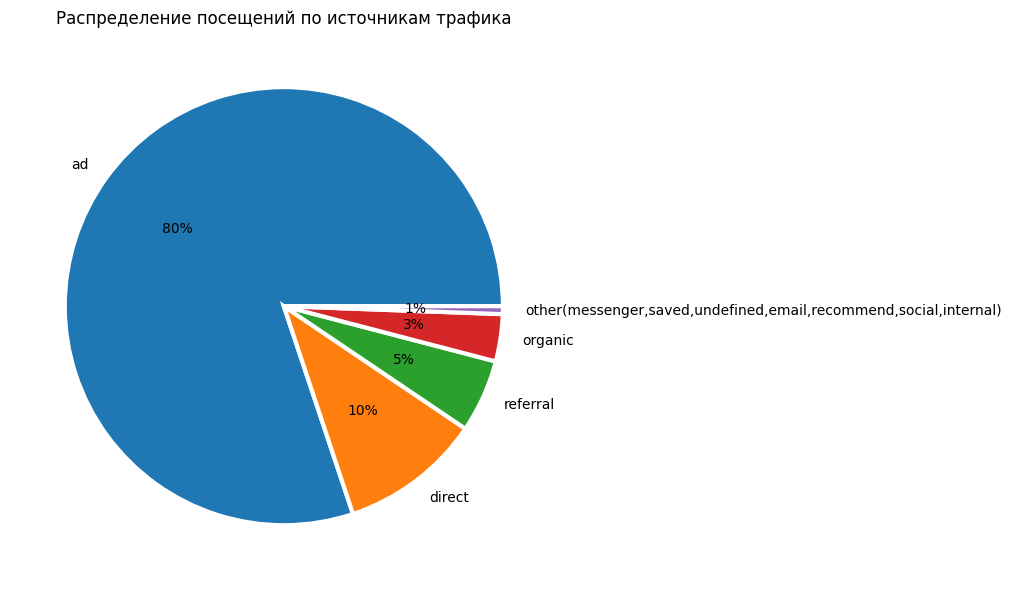

In [610]:
visits_grouped = visits.groupby('TrafficSource').agg({'visitID': 'count'}).nlargest(4,'visitID')
visits_grouped = pd.concat([visits_grouped,pd.DataFrame(index=[f"other({','.join(list(set(visits['TrafficSource'].unique())
                                                                                      -set(visits_grouped.index)))})"],
                                                        data=visits['visitID'].count()-visits_grouped['visitID'].sum(),
                                                        columns=['visitID'])])
visits_grouped.plot(kind='pie', 
                    y='visitID', 
                    figsize=(15,6),
                    legend=False,
                    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
                    autopct='%1.0f%%',
                    title='Распределение посещений по источникам трафика').set(ylabel='')
plt.tight_layout()

На графике мы видим, что 80% трафика генерируется рекламой и лишь 3% органического трафика.

In [639]:
visits[visits['TrafficSource']=='ad'].groupby('AdvEngine').agg({'visitID': 'count'}).sort_values(by='visitID',ascending=False)

,visitID
AdvEngine,
ya_direct,23981
ya_undefined,1342
unknown,145
google_adwords,23
vkontakte,7
target_mail_ru,3
facebook,1


In [641]:
visits[visits['TrafficSource']=='direct'].groupby(['AdvEngine','UTMCampaign']).agg({'visitID': 'count'}).sort_values(by='visitID',ascending=False)

visitID
AdvEngine    UTMCampaign         
ya_undefined not_defined     3294
             apr2023           14
             dniriteila        13
             franch             1

In [615]:
visits[visits['TrafficSource']=='ad']['AdvEngine'].unique()a

array(['ya_direct', 'ya_undefined', 'google_adwords', 'unknown',
       'facebook', 'vkontakte', 'target_mail_ru'], dtype=object)

<Axes: >

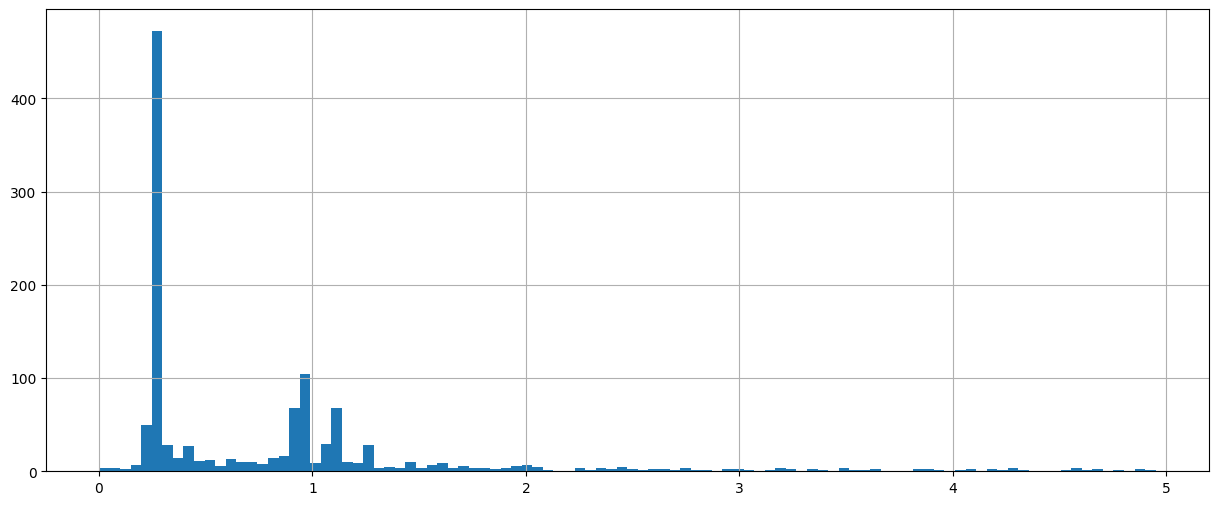

In [327]:
(visits[(visits['visitDuration']<300) & (visits['bounce']==0) & (visits['UTMSource']=='utm_sourse=auto')]['visitDuration']/60).hist(bins=100, figsize=(15,6))

In [290]:
visits.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
visitID,31833.0,NaN,NaN,NaN,4445860278186115584.0,3457787294992285184.0,390503913750575.0,2314367076466163712.0,4047144377677250560.0,5725402474375020544.0,18445430130467930112.0
counterID,31833.0,NaN,NaN,NaN,86883361.0,0.0,86883361.0,86883361.0,86883361.0,86883361.0,86883361.0
watchIDs,31833,31833,"[540382993342791808,540386923681415183]",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,31833,335,2023-05-01,1047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dateTime,31833,31744,2023-01-15 20:20:26,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dateTimeUTC,31833,31744,2023-01-15 16:20:26,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isNewUser,31833.0,NaN,NaN,NaN,0.784438,0.411218,0.0,1.0,1.0,1.0,1.0
startURL,31833,318,https://franchise.fermer-centr.shop/,30851,NaN,NaN,NaN,NaN,NaN,NaN,NaN
endURL,31833,323,https://franchise.fermer-centr.shop/,29618,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pageViews,31833.0,NaN,NaN,NaN,1.164232,0.591826,1.0,1.0,1.0,1.0,24.0


In [258]:
f"other({','.join(list(set(visits['TrafficSource'].unique())-set(visits_grouped.index)))})"

'other(messenger,saved,undefined,email,recommend,social)'

In [268]:
visits_grouped = visits.groupby('TrafficSource').agg({'visitID': 'count'}).nlargest(4,'visitID')

In [282]:
visits_grouped

,visitID
UTMSource,
yandex,25414
utm_sourse=auto,1526
mts_tg,189
instagram,67


In [283]:
visits.groupby('UTMSource').agg({'visitID': 'count'})

,visitID
UTMSource,
bisplatform.rass,38
businessmens,8
confa,2
exhibition,15
facebook,1
fr.mall,22
fr.mall.rass,18
google,21
instagram,67


In [284]:
visits_grouped = visits.groupby('TrafficSource').agg({'visitID': 'count'}).nlargest(4,'visitID')
visits_grouped = pd.concat([visits_grouped,pd.DataFrame(index=[f"other({','.join(list(set(visits['TrafficSource'].unique())-set(visits_grouped.index)))})"],
                                      data=visits['visitID'].count()-visits_grouped['visitID'].sum(),columns=['visitID'])])

In [411]:
visits[visits['TrafficSource'] == 'referral'].groupby('UTMSource').agg({'visitID':'count'})

,visitID
UTMSource,
fr.mall,22
mts_tg,6
utm_sourse=auto,5


In [66]:
visits.rename(columns={col:col[5:] if col[5] != '<' else col[18:] for col in list(visits.columns)}, inplace=True)

In [286]:
visits.UTMSource.unique()

array(['yandex', nan, 'utm_sourse=auto', 'vk', 'google', 'mts_tg',
       'fr.mall', 'pressa', 'instagram', 'telegram', 'package',
       'businessmens', 'fr.mall.rass', 'exhibition', 'vystavka',
       'bisplatform.rass', 'facebook', 'yandex.dzen',
       'Продолжаем покупать аккаунты Google Ads = t.me/ads_skupka_support1_bot',
       'vkontakte', 'mytarget', 'confa'], dtype=object)

In [307]:
visits.columns

Index(['visitID', 'counterID', 'watchIDs', 'date', 'dateTime', 'dateTimeUTC',
       'isNewUser', 'startURL', 'endURL', 'pageViews', 'visitDuration',
       'bounce', 'ipAddress', 'regionCountry', 'regionCity', 'clientID',
       'counterUserIDHash', 'networkType', 'goalsID', 'goalsSerialNumber',
       'goalsDateTime', 'TrafficSource', 'AdvEngine', 'ReferalSource',
       'SearchEngineRoot', 'SocialNetwork', 'referer', 'DirectClickOrder',
       'DirectBannerGroup', 'DirectClickBanner', 'DirectClickOrderName',
       'ClickBannerGroupName', 'DirectClickBannerName', 'DirectPhraseOrCond',
       'DirectPlatformType', 'DirectPlatform', 'DirectConditionType',
       'UTMCampaign', 'UTMContent', 'UTMMedium', 'UTMSource', 'UTMTerm',
       'openstatAd', 'openstatCampaign', 'openstatService', 'openstatSource',
       'clientTimeZone', 'deviceCategory', 'mobilePhone', 'mobilePhoneModel',
       'operatingSystemRoot', 'operatingSystem', 'browser', 'cookieEnabled',
       'recommendationSystem'

In [309]:
visits.groupby('bounce').count()

,visitID,counterID,watchIDs,date,dateTime,dateTimeUTC,isNewUser,startURL,endURL,pageViews,...,clientTimeZone,deviceCategory,mobilePhone,mobilePhoneModel,operatingSystemRoot,operatingSystem,browser,cookieEnabled,recommendationSystem,messenger
bounce,,,,,,,,,,,,,,,,,,,,,
0,22410,22410,22410,22410,22410,22410,22410,22410,22410,22410,...,22410,22410,16960,17041,22406,22406,22407,22410,22410,22410
1,9423,9423,9423,9423,9423,9423,9423,9423,9423,9423,...,9423,9423,7735,7883,9421,9421,9421,9423,9423,9423


In [ ]:
calls

In [642]:
autocall_visits = visits.query("UTMSource=='utm_sourse=auto'").groupby('date').agg({'visitID':'count','main_goal_achieved':'sum'}).reset_index()

In [674]:
autocall_visits

,date,visitID,main_goal_achieved
0,2023-06-05,1,0
1,2023-06-06,6,2
2,2023-06-07,31,5
3,2023-06-08,31,2
4,2023-06-09,4,1
5,2023-06-10,2,1
6,2023-06-13,16,1
7,2023-06-14,16,6
8,2023-06-15,19,1
9,2023-06-16,5,0


In [644]:
autocall_visits['date'] = pd.to_datetime(autocall_visits['date'])

In [645]:
calls_visits = calls.merge(autocall_visits)

In [652]:
calls_visits['visit_conversion'] = round(calls_visits['visitID'] / calls_visits['positive_answers'] * 100, 2)
calls_visits['contact_conversion'] = round(calls_visits['main_goal_achieved'] / calls_visits['positive_answers'] * 100, 2)
calls_visits['visit_conversion_from_all'] = round(calls_visits['visitID'] / calls_visits['campaign_volume'] * 100, 2)
calls_visits['contact_conversion_from_all'] = round(calls_visits['main_goal_achieved'] / calls_visits['campaign_volume'] * 100, 2)

In [653]:
calls_visits.describe(include='all').T

,count,mean,min,25%,50%,75%,max,std
date,57,2023-08-18 14:44:12.631578880,2023-06-06 00:00:00,2023-07-10 00:00:00,2023-08-02 00:00:00,2023-09-24 00:00:00,2023-11-27 00:00:00,NaN
positive_answers,57.0,102.052632,18.0,52.0,83.0,133.0,316.0,66.884875
campaign_volume,57.0,26969.807018,5018.0,14992.0,15000.0,30002.0,119987.0,20929.614204
sum_cost,57.0,5891.828596,0.0,3356.85,4064.17,7072.36,16276.17,3879.355835
visitID,57.0,22.964912,3.0,16.0,22.0,28.0,72.0,13.67083
main_goal_achieved,57.0,3.385965,0.0,1.0,3.0,5.0,13.0,2.637331
visit_conversion,57.0,25.705439,3.26,19.59,23.71,32.26,61.11,11.69844
contact_conversion,57.0,3.632982,0.0,1.53,3.42,5.0,10.26,2.347309
visit_conversion_from_all,57.0,0.104035,0.01,0.06,0.09,0.13,0.44,0.067977
contact_conversion_from_all,57.0,0.016667,0.0,0.01,0.01,0.02,0.1,0.015849


`mean` - среднее значение

`50%` - медианное значение

`positive_answers` - количество положительных ответов полученных в течение автообзвонов

`campaign_volume` - количество номеров, учавствовавших в автообзвоне

`sum_cost` - сумма затрат на звонки

`visitID` - количество пользователей посетивших сайт

`main_goal_achieved` - количество пользователей, которые заполнили форму на сайте

`visit_conversion` - % перехода положительных ответов в рамках обзвонной кампании в визиты на сайт

`contact_conversion` - % перехода положительных ответов в рамках обзвонной кампании в заполнение формы

`visit_conversion_from_all` - % перехода всех обзвонов в визиты на сайт

`contact_conversion_from_all` - % перехода всех обзвонов в заполнение формы

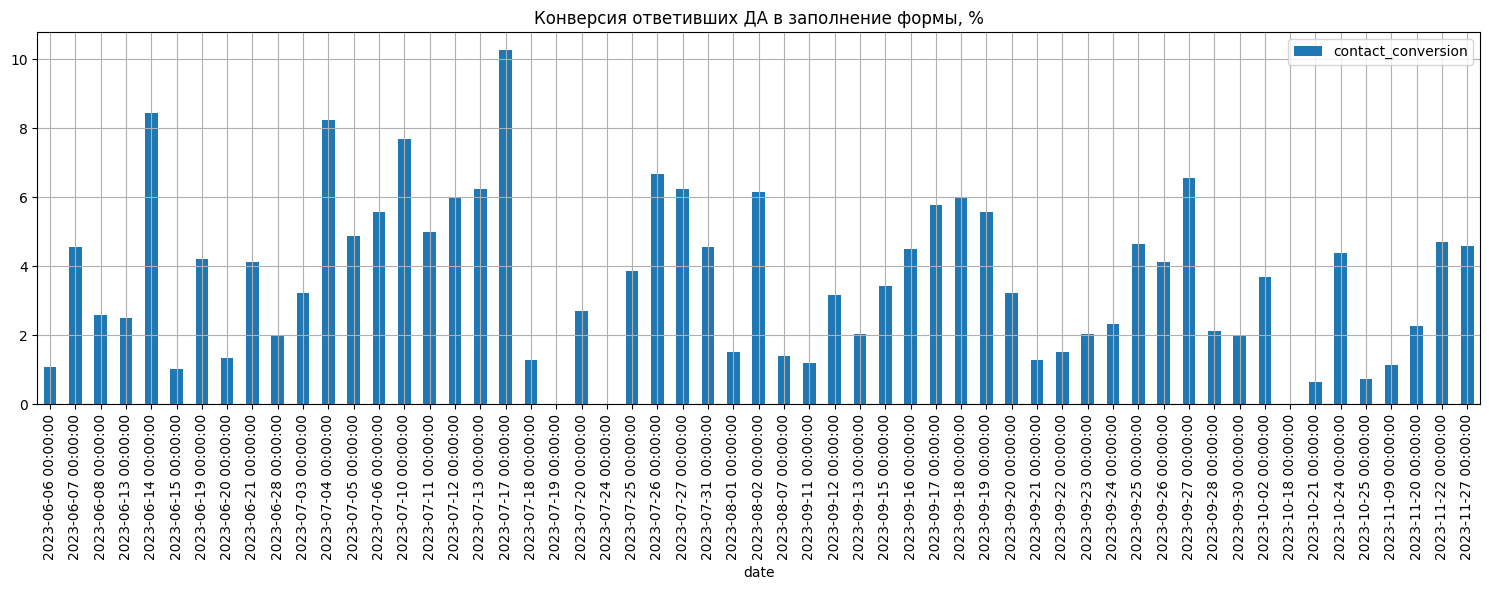

In [690]:
calls_visits.plot(x='date', y = 'contact_conversion', figsize=(15,6),title='Конверсия ответивших ДА в заполнение формы, %', grid=True, kind='bar')
plt.tight_layout()
plt.show()

In [ ]:
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=srv-logist-rc;DATABASE=leads;UID=py_user;PWD=MontyPython')
cursor = conn.cursor()
cursor.execute("""  select h.date,
		 sum(case when d.user_choice>0 then d.user_choice else 0 end) positive_answers,
		 count(d.phone) as campaign_volume,
		 sum(d.cost) as sum_cost
  from [leads].[dbo].[calls_from_zvonok] d
  join [leads].[dbo].[calls_from_zvonok_head] h
	on h.campaign_id=d.campaign_id
  where h.client_id=1
  group by h.date
  order by h.date""")
rows = cursor.fetchall(()
calls = pd.DataFrame(data=[tuple(row) for row in rows],columns=[col[0] for col in cursor.description])

In [747]:
conn = pyodbc.connect('DRIVER={SQL Server};SERVER=srv-logist-rc;DATABASE=leads;UID=py_user;PWD=MontyPython')
cursor = conn.cursor()
cursor.execute(""" select distinct h.date,datepart(ww,h.date) as week_num,
		 sum(case when d.user_choice>0 then d.user_choice else 0 end) over (partition by h.date) as Количество_Позитивных_Ответов_День,
		 sum(case when d.user_choice>0 then d.user_choice else 0 end) over (partition by datepart(ww,h.date)) as Количество_Позитивных_Ответов_Неделя,
		 count(d.phone) over (partition by h.date) as Сумм_Объем_Кампаний_День,
		 count(d.phone) over (partition by datepart(ww,h.date)) as Сумм_Объем_Кампаний_Неделя,
		 sum(d.cost) over (partition by h.date) as Затраты_день,
		 sum(d.cost) over (partition by  datepart(ww,h.date)) as Затраты_неделя
  from [leads].[dbo].[calls_from_zvonok] d
  join [leads].[dbo].[calls_from_zvonok_head] h
	on h.campaign_id=d.campaign_id
  where h.client_id=1
  order by h.date""")
rows = cursor.fetchall()
calls = pd.DataFrame(data=[tuple(row) for row in rows],columns=[col[0] for col in cursor.description])
merged = visits.merge(calls,how='left', left_on='Дата_Визита',right_on='date').drop(columns=['date','week_num']).fillna(0)
merged.to_excel('visits_data.xlsx')

In [741]:
visits

,ИД_Визита,Дата_Визита,dateTime,Новый_Пользователь,Просмотрено страниц,"Длительность, сек",bounce,Страна,Город,Источник трафика,...,DirectConditionType,UTMCampaign,UTMContent,UTMMedium,UTMSource,UTMTerm,Форма заполнена,Год,Неделя,День_Недели
0,540382993342791808,2023-02-13,2023-02-13 03:36:37,1,1,15,0,Russia,Moscow,ad,...,11,mk_avto_msk,13377636888,cpc,yandex,---autotargeting,0,2023,7,1
1,1042878070601285833,2023-03-07,2023-03-07 08:04:24,0,1,66,0,Russia,Khabarovsk,ad,...,retargeting,78722118,12814481453,cpc,yandex,not_defined,0,2023,10,2
2,1505777749250539819,2023-03-27,2023-03-27 18:34:46,1,1,14,0,Russia,Moscow,ad,...,11,mk_interes_msk,13645007273,cpc,yandex,---autotargeting,0,2023,13,1
3,281231775675711627,2023-02-01,2023-02-01 17:00:14,0,2,118,0,Russia,Moscow,organic,...,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,1,2023,5,3
4,5155359286003499066,2023-09-04,2023-09-04 21:48:54,1,1,15,0,Russia,Krasnoyarsk,ad,...,11,86636784,13958820869,cpc,yandex,---autotargeting,0,2023,36,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32603,3302869941050671167,2023-06-15,2023-06-15 02:50:48,1,1,15,0,Russia,Moscow,ad,...,11,master_campanii_ruch,13958813345,cpc,yandex,not_defined,0,2023,24,4
32604,7303625377326563329,2023-12-08,2023-12-08 18:11:59,1,1,91,0,Russia,Moscow,ad,...,11,97189006,15101267198,cpc,yandex,---autotargeting,1,2023,49,5
32605,2290193455713616147,2023-05-01,2023-05-01 09:46:34,1,1,19,0,Russia,Cheboksary,ad,...,11,master_campanii_interes,13670561716,cpc,yandex,---autotargeting,0,2023,18,1
32606,6313803765557231634,2023-10-26,2023-10-26 01:20:49,0,1,15,0,Russia,Domodedovo,direct,...,not_defined,not_defined,not_defined,not_defined,not_defined,not_defined,0,2023,43,4


In [753]:
merged = visits.merge(calls,how='left', left_on='Дата_Визита',right_on='date').drop(columns=['date','week_num']).fillna(0)
merged.to_excel('visits_data.xlsx')

In [758]:
merged.to_excel('visits_data.xlsx')

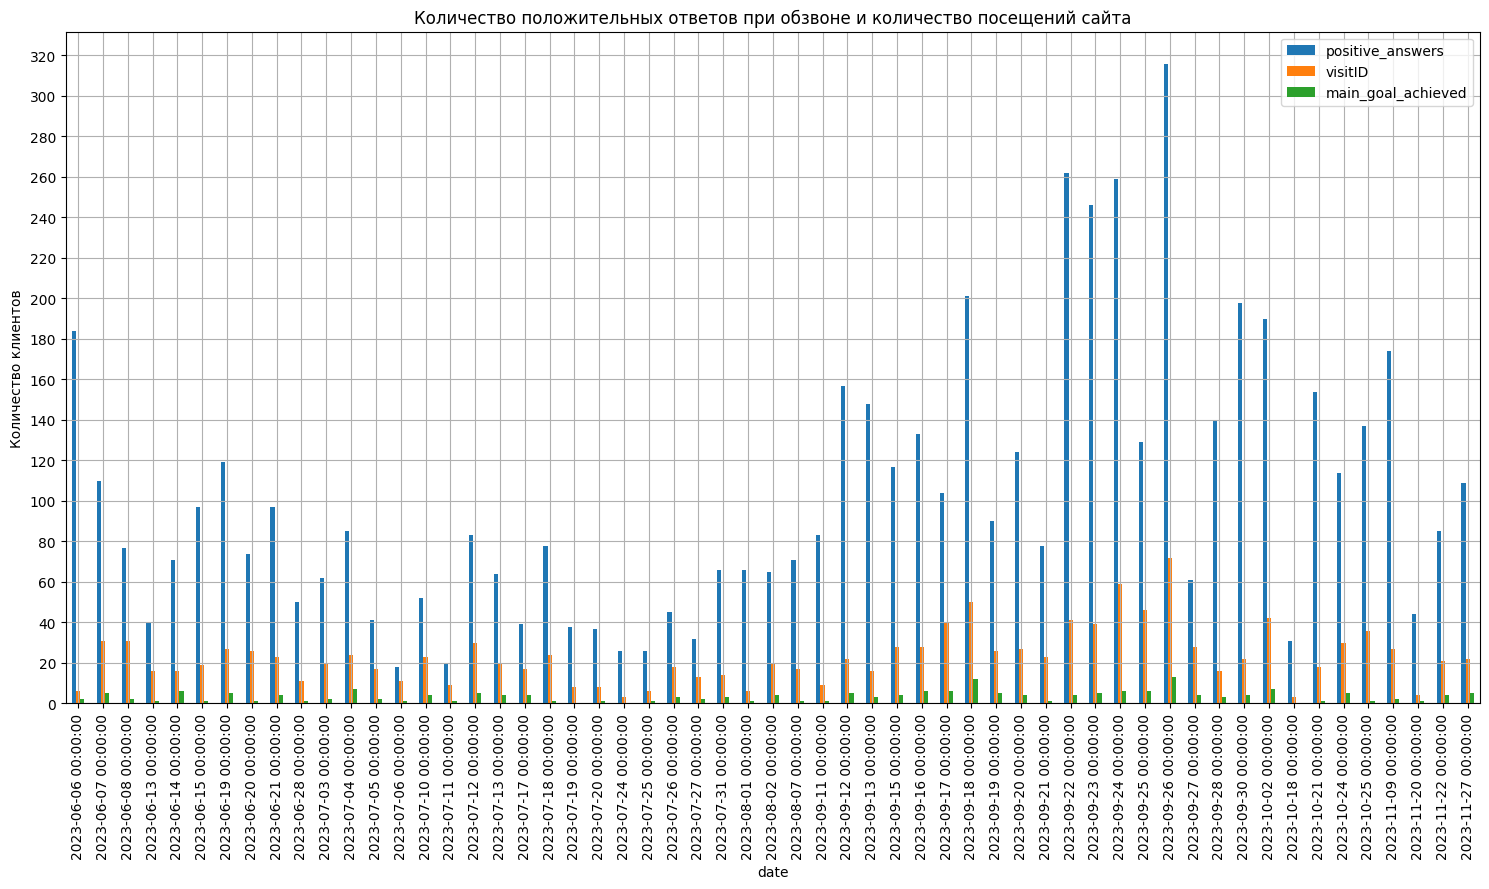

In [686]:
calls.merge(autocall_visits).plot(kind='bar',
                                  x='date', 
                                  y = ['positive_answers', 'visitID','main_goal_achieved'], 
                                  figsize=(15,9),
                                  title='Количество положительных ответов при обзвоне и количество посещений сайта',
                                  grid=True,
                                  ylabel='Количество клиентов')
plt.yticks(range(0,340,20))
plt.tight_layout()
plt.show()

In [675]:
list(calls.merge(autocall_visits).date.sort_values().unique())

[Timestamp('2023-06-06 00:00:00'),
 Timestamp('2023-06-07 00:00:00'),
 Timestamp('2023-06-08 00:00:00'),
 Timestamp('2023-06-13 00:00:00'),
 Timestamp('2023-06-14 00:00:00'),
 Timestamp('2023-06-15 00:00:00'),
 Timestamp('2023-06-19 00:00:00'),
 Timestamp('2023-06-20 00:00:00'),
 Timestamp('2023-06-21 00:00:00'),
 Timestamp('2023-06-28 00:00:00'),
 Timestamp('2023-07-03 00:00:00'),
 Timestamp('2023-07-04 00:00:00'),
 Timestamp('2023-07-05 00:00:00'),
 Timestamp('2023-07-06 00:00:00'),
 Timestamp('2023-07-10 00:00:00'),
 Timestamp('2023-07-11 00:00:00'),
 Timestamp('2023-07-12 00:00:00'),
 Timestamp('2023-07-13 00:00:00'),
 Timestamp('2023-07-17 00:00:00'),
 Timestamp('2023-07-18 00:00:00'),
 Timestamp('2023-07-19 00:00:00'),
 Timestamp('2023-07-20 00:00:00'),
 Timestamp('2023-07-24 00:00:00'),
 Timestamp('2023-07-25 00:00:00'),
 Timestamp('2023-07-26 00:00:00'),
 Timestamp('2023-07-27 00:00:00'),
 Timestamp('2023-07-31 00:00:00'),
 Timestamp('2023-08-01 00:00:00'),
 Timestamp('2023-08-

In [678]:
plt.xticks([Timestamp('2023-06-01 00:00:00'),
 Timestamp('2023-06-10 00:00:00'),
 Timestamp('2023-06-20 00:00:00'),
 Timestamp('2023-07-01 00:00:00'),
 Timestamp('2023-07-10 00:00:00'),
 Timestamp('2023-07-20 00:00:00'),
 Timestamp('2023-08-01 00:00:00'),
 Timestamp('2023-08-10 00:00:00'),
 Timestamp('2023-08-20 00:00:00'),
 Timestamp('2023-09-01 00:00:00'),
 Timestamp('2023-09-10 00:00:00'),
 Timestamp('2023-09-20 00:00:00'),
 Timestamp('2023-10-01 00:00:00'),
 Timestamp('2023-10-10 00:00:00'),
 Timestamp('2023-10-20 00:00:00'),
 Timestamp('2023-11-01 00:00:00'),
 Timestamp('2023-11-10 00:00:00'),
 Timestamp('2023-11-20 00:00:00'),
 Timestamp('2023-12-01 00:00:00'),
 Timestamp('2023-12-10 00:00:00')])

NameError: name 'Timestamp' is not defined

In [379]:
autocall_visits

,date,visitID
0,2023-06-05,1
1,2023-06-06,6
2,2023-06-07,31
3,2023-06-08,31
4,2023-06-09,4
5,2023-06-10,2
6,2023-06-13,16
7,2023-06-14,16
8,2023-06-15,19
9,2023-06-16,5


In [119]:
visits_grouped = visits.groupby('date').agg({'visitID':'count'}).reset_index()

In [120]:
visits_grouped['date'] = pd.to_datetime(visits_grouped['date'])

<Axes: xlabel='date'>

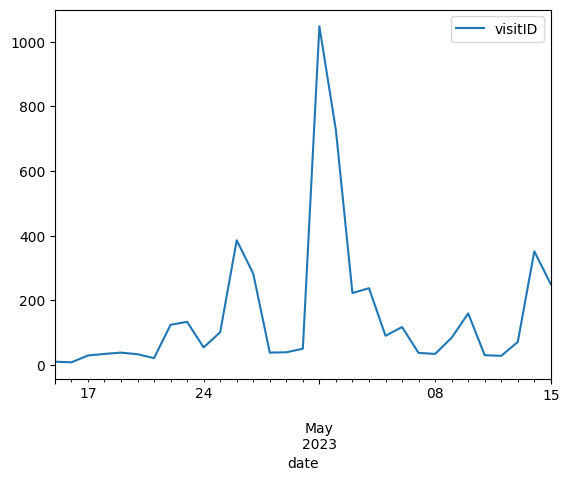

In [127]:
visits_grouped.query('date>="2023-04-15" and date<="2023-05-15"').plot(x='date', y='visitID')

In [134]:
visits.shape

(31099, 56)

<Axes: xlabel='date'>

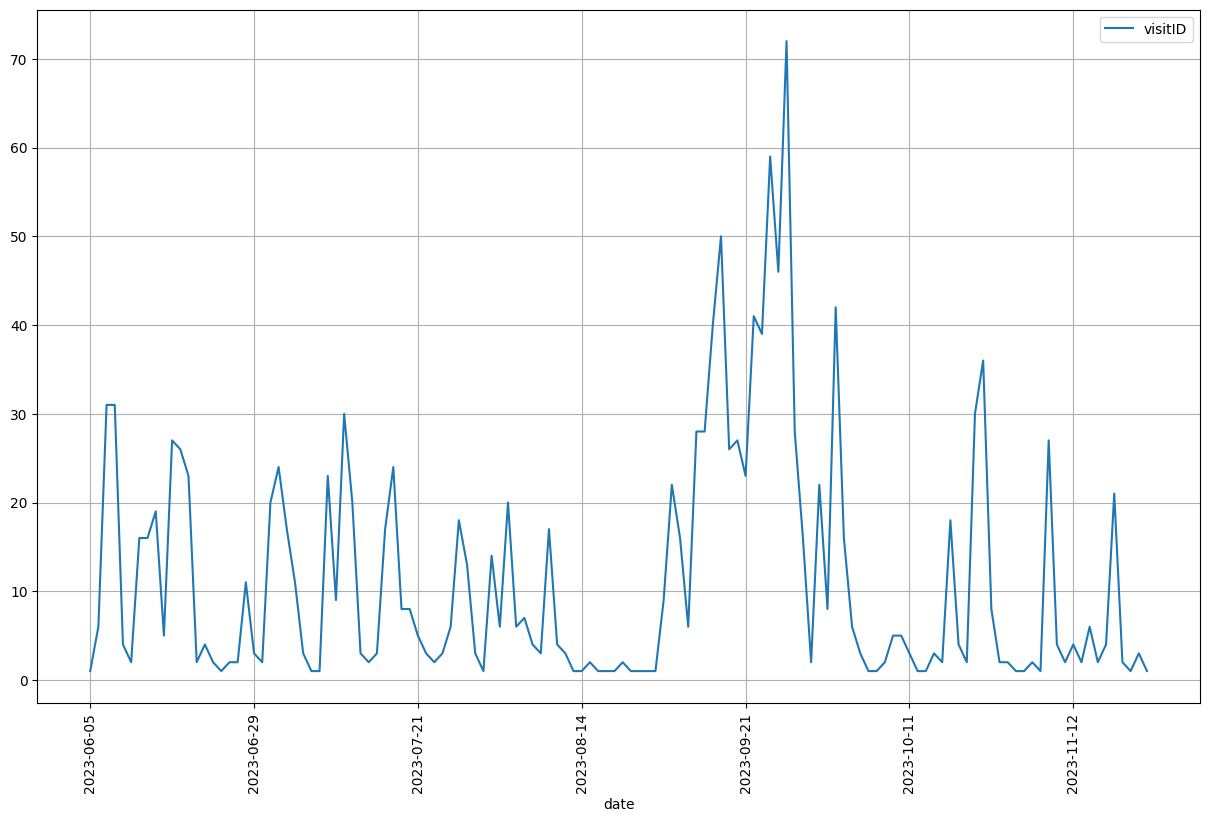

In [152]:
visits[visits['UTMSource']=='utm_sourse=auto'].groupby(['date']).agg({'visitID':'count'}).plot(rot=90,grid=True,figsize=(15,9))

<Axes: xlabel='UTMMedium'>

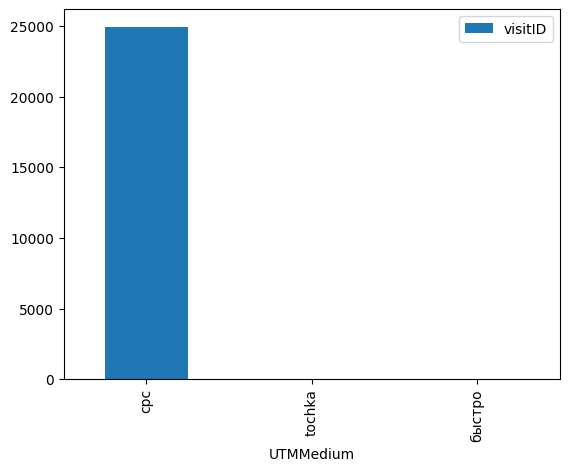

In [156]:
visits[visits['TrafficSource']=='ad'].groupby(['UTMMedium']).agg({'visitID':'count'}).plot(kind='bar')

<Axes: xlabel='date'>

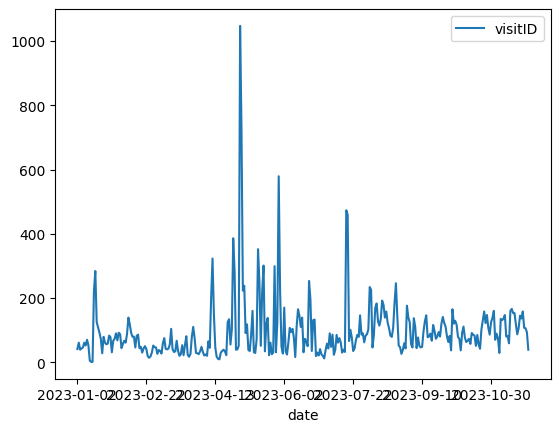

In [121]:
visits.groupby('date').agg({'visitID':'count'}).reset_index().plot(x='date', y='visitID')

In [103]:
visits['watchIDs'].astype('UInt64')

ValueError: invalid literal for int() with base 10: '[281231775675711627,281261739061543127,281262730776412179,281262914043117707,281235713390805203]'

In [105]:
visits.loc[visits['pageViews']==24,'watchIDs'].to_list()

['[3174149519500378542,3174169305485410504,3174186260267270400,3174202628037935305,3174283186925732045,3174289989808160787,3174293842459099172,3174294893339869189,3174300635860304230,3174309386278142022,3174325128229552169,3174394764345999543,3174413457926914351,3174504998964035726,3174510266978140311,3174518292103299250,3174524548617076777,3174527124469186656,3174529366329393189,3174644157911138598,3174655966985584699,3174673361520296154,3174702753777975538,3174717595393720440,3174153476779803053,3174173370582827241,3174190216069775558,3174206653631562010,3174287247052636168,3174298840348229895,3174304712697577621,3174313382867370332,3174329162367238529,3174398649390072237,3174417454840938693,3174508917839364111,3174514208303743337,3174522185581592833,3174654830224343093,3174701101773488189,3174706863094104174,3174721591629578534]']

In [91]:
visits.loc[visits['pageViews']==24,'watchIDs'].values[0].replace('[','').replace(']','').split(',')

['3174149519500378542',
 '3174169305485410504',
 '3174186260267270400',
 '3174202628037935305',
 '3174283186925732045',
 '3174289989808160787',
 '3174293842459099172',
 '3174294893339869189',
 '3174300635860304230',
 '3174309386278142022',
 '3174325128229552169',
 '3174394764345999543',
 '3174413457926914351',
 '3174504998964035726',
 '3174510266978140311',
 '3174518292103299250',
 '3174524548617076777',
 '3174527124469186656',
 '3174529366329393189',
 '3174644157911138598',
 '3174655966985584699',
 '3174673361520296154',
 '3174702753777975538',
 '3174717595393720440',
 '3174153476779803053',
 '3174173370582827241',
 '3174190216069775558',
 '3174206653631562010',
 '3174287247052636168',
 '3174298840348229895',
 '3174304712697577621',
 '3174313382867370332',
 '3174329162367238529',
 '3174398649390072237',
 '3174417454840938693',
 '3174508917839364111',
 '3174514208303743337',
 '3174522185581592833',
 '3174654830224343093',
 '3174701101773488189',
 '3174706863094104174',
 '31747215916295

In [101]:
views['ym:pv:watchID'].astype('uint64')

0        6087112506268975104
1        6088360770636087296
2        6088364607650137088
3        6087558446422425600
4        6087562279655309312
                ...         
73376      39235151400796352
73377      39235907626205256
73378      60373821399236624
73379      60377784053137584
73380      60388434809192744
Name: ym:pv:watchID, Length: 73381, dtype: uint64

In [67]:
visits[]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31099 entries, 0 to 31098
Data columns (total 56 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   visitID                31099 non-null  uint64 
 1   counterID              31099 non-null  int64  
 2   watchIDs               31099 non-null  object 
 3   date                   31099 non-null  object 
 4   dateTime               31099 non-null  object 
 5   dateTimeUTC            31099 non-null  object 
 6   isNewUser              31099 non-null  int64  
 7   startURL               31099 non-null  object 
 8   endURL                 31099 non-null  object 
 9   pageViews              31099 non-null  int64  
 10  visitDuration          31099 non-null  int64  
 11  bounce                 31099 non-null  int64  
 12  ipAddress              31099 non-null  object 
 13  regionCountry          31051 non-null  object 
 14  regionCity             28872 non-null  object 
 15  cl